# ID Graph Exploration

In [1]:
import json
import os
import pprint

from jinja2 import Template
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
import snowflake.connector
import yaml

In [2]:
# ID stitcher model name
model_name = "user_id_stitcher"

In [3]:
# Retrieve connection name from pb_project.yaml
with open("../pb_project.yaml", "r") as f:
    connection_name = yaml.load(f, Loader=yaml.FullLoader).get("connection")

# Retrieve connection credentials from ~/.pb/siteconfig.yaml
with open(f"{os.path.expanduser('~')}/.pb/siteconfig.yaml") as f:
    creds = yaml.load(f, Loader=yaml.FullLoader)["connections"][connection_name]["outputs"]["dev"]

# Create Snowflake connection and cursor
ctx = snowflake.connector.connect(
    user=creds["user"],
    password=creds["password"],
    account=creds["account"],
    warehouse=creds["warehouse"],
    database=creds["dbname"],
    schema=creds["schema"]
)
cur = ctx.cursor()

In [4]:
# Retrieve ID graph from Snowflake and load it into a pandas DataFrame
sql = f"SELECT * FROM {creds['dbname']}.{creds['schema']}.{model_name}"
id_graph = cur.execute(sql).fetch_pandas_all()

# Preview the first five rows
id_graph.head()

,USER_MAIN_ID,OTHER_ID,OTHER_ID_TYPE,VALID_AT,FIRST_SEEN_AT
0,rid9e6998173ae3f2a421c43d5cb9246638,deliabednar@junior-girlfriend.com,email,2024-03-09 13:56:51.141,2024-03-09 13:56:51.141
1,ridda78f13cc059857d4a7b3926ee23864b,69b5d69d-c64a-4a7a-b476-e837f9ea3761,anonymous_id,2024-03-09 13:57:23.400,2024-03-09 13:57:23.400
2,rid5c32c5a1355e43b4760318dfa7fa840a,e6c1f19b-6a95-46e4-ae4c-a6aeaf8c030c,anonymous_id,2024-03-09 13:56:49.172,2024-03-09 13:56:49.172
3,rid0b747f0f37377e61c59f7b24801e336b,482d17b6-dc36-4cb9-b2c5-8a15f2f32d0a,anonymous_id,2024-03-09 13:57:06.291,2024-03-09 13:57:06.291
4,rid3df8bda9dddd86a68bbf53cd978030ee,4043bbb1-7f35-406c-b5e6-12a6c4036c3f,anonymous_id,2024-03-09 13:57:01.232,2024-03-09 13:57:01.232


In [5]:
# DataFrame informaiton
id_graph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   USER_MAIN_ID   265 non-null    object        
 1   OTHER_ID       265 non-null    object        
 2   OTHER_ID_TYPE  265 non-null    object        
 3   VALID_AT       265 non-null    datetime64[ns]
 4   FIRST_SEEN_AT  265 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 10.5+ KB


In [6]:
# Descriptive statistics for numeric columns
id_graph.describe()

,VALID_AT,FIRST_SEEN_AT
count,265,265
mean,2024-03-09 15:55:55.359780864,2024-03-09 15:55:55.357886720
min,2024-03-09 13:54:48.123000,2024-03-09 13:54:48.123000
25%,2024-03-09 13:56:48.971000064,2024-03-09 13:56:48.971000064
50%,2024-03-09 13:57:01.032000,2024-03-09 13:57:01.032000
75%,2024-03-09 13:57:08.920000,2024-03-09 13:57:08.920000
max,2024-03-13 23:15:15.793000,2024-03-13 23:15:15.793000


In [7]:
# Descriptive statistics for non-numeric columns
id_graph.describe(include=object)

,USER_MAIN_ID,OTHER_ID,OTHER_ID_TYPE
count,265,265,265
unique,147,265,4
top,ridfe6f4d95aa306184d6462db1d7f5d57c,deliabednar@junior-girlfriend.com,anonymous_id
freq,5,1,148


In [8]:
# Main ID column name and main ID series
rudder_id = id_graph.columns[0]
main_ids = id_graph[rudder_id]

# ID metrics
print("Profile count:            ", len(main_ids.unique()))
print("ID count:                 ", len(id_graph["OTHER_ID"].unique()))
print("Average ID count/profile: ", "{:.2f}".format(id_graph.groupby(rudder_id)["OTHER_ID"].count().mean()))
print("Maximum ID count/profile: ", main_ids.value_counts().max())

Profile count:             147
ID count:                  265
Average ID count/profile:  1.80
Maximum ID count/profile:  5


In [9]:
# Frequency of each ID type
id_graph["OTHER_ID_TYPE"].value_counts()

OTHER_ID_TYPE
anonymous_id    148
email            39
phone            39
user_id          39
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

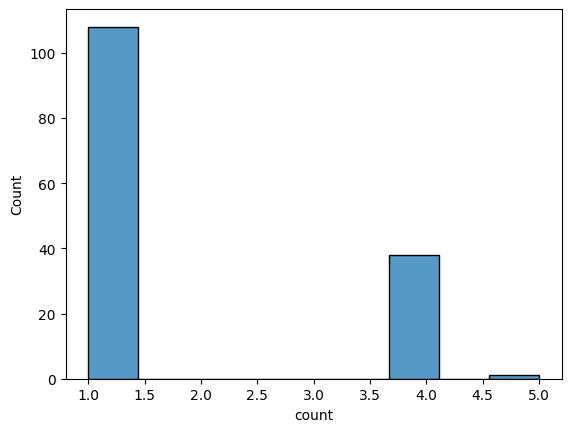

In [10]:
# Visualize distribution of ID count per profile
main_id_counts = main_ids.value_counts()
sns.histplot(main_id_counts)

In [11]:
# Distribution of ID count per profile
profiles_per_id_count = main_ids.value_counts().value_counts()
pd.DataFrame({"Profile Count":profiles_per_id_count.index, "ID Count":profiles_per_id_count.values})

,Profile Count,ID Count
0,1,108
1,4,38
2,5,1


In [12]:
# Ten profiles with most stitched IDs
main_id_counts.nlargest(10)

USER_MAIN_ID
ridfe6f4d95aa306184d6462db1d7f5d57c    5
rid9e6998173ae3f2a421c43d5cb9246638    4
rid2f5508b9b92013fb78b81bfbd90ebeb1    4
ridec001945cdca59f2f606c4479ee49b6f    4
rid32c964b8202e852d0df47920b8a78762    4
rid2b0b00603a0be60c70c22cf53461e076    4
rid641e30cce8c36bc063605eed5c3fee4d    4
rid0f4db0afa3a9a064321df4da8c82b3f0    4
ridb11174fa0c128328d1054cdb4b96da7a    4
rid3da3d3b7da212eb8392bea06e1d8a942    4
Name: count, dtype: int64

In [13]:
# Profile with most IDs
most_frequent_main_id = main_ids.mode()[0]
id_graph[id_graph[rudder_id] == most_frequent_main_id]

,USER_MAIN_ID,OTHER_ID,OTHER_ID_TYPE,VALID_AT,FIRST_SEEN_AT
68,ridfe6f4d95aa306184d6462db1d7f5d57c,563fc39a-9d0a-49c1-b669-4650522970a3,anonymous_id,2024-03-13 23:15:15.792,2024-03-13 23:15:15.791
81,ridfe6f4d95aa306184d6462db1d7f5d57c,b5fe5115-84c5-493d-a91c-d25e55bfcdda,anonymous_id,2024-03-13 23:15:15.793,2024-03-13 23:15:15.793
83,ridfe6f4d95aa306184d6462db1d7f5d57c,521-710-4869,phone,2024-03-13 23:15:15.792,2024-03-13 23:15:15.792
142,ridfe6f4d95aa306184d6462db1d7f5d57c,hoytmacejkovic@those-mortise.com,email,2024-03-13 23:15:15.792,2024-03-13 23:15:15.792
196,ridfe6f4d95aa306184d6462db1d7f5d57c,b89902e2-e23d-45af-87f1-2664927ed77e,user_id,2024-03-13 23:15:15.792,2024-03-13 23:15:15.792


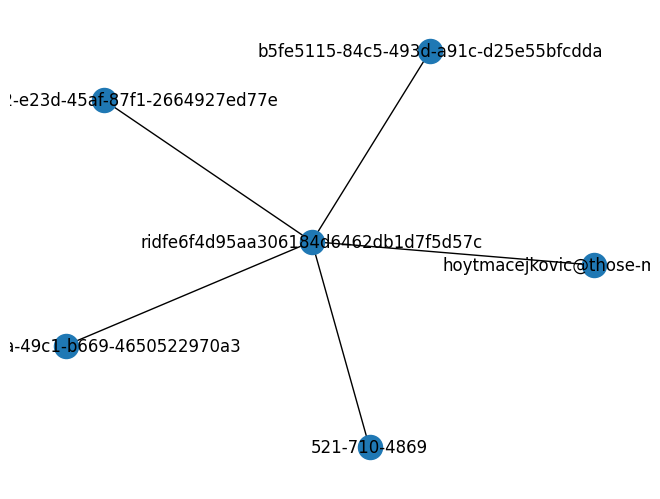

In [14]:
# Visualize ID graph for profile with most IDs
G = nx.Graph()
for index, row in id_graph[id_graph[rudder_id] == most_frequent_main_id].iterrows():
    G.add_nodes_from([
        (row[rudder_id], {"type": "main_id"}),
        (row["OTHER_ID"], {"type": row["OTHER_ID_TYPE"]}),
    ])
    G.add_edge(row[rudder_id], row["OTHER_ID"])

plt.tight_layout()
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

In [15]:
# Retrieve latest model name and edges table and load them into a pandas DataFrame
sql = f"""
select
    'material_' || model_name || '_' || model_hash || '_' || seq_no  as model_name,
    'material_' || model_name || '_' || model_hash || '_' || seq_no || '_internal_edges' as edges_table
from {creds['dbname']}.{creds['schema']}.MATERIAL_REGISTRY_4
where
    model_type = 'id_stitcher'
    and metadata:complete:status = 2
qualify rank() over (partition by model_name order by end_ts desc) = 1
limit 1;
"""
material_names = cur.execute(sql).fetch_pandas_all()

# Preview data
material_names.head()

,MODEL_NAME,EDGES_TABLE
0,material_user_id_stitcher_d13cdb3f_6,material_user_id_stitcher_d13cdb3f_6_internal_...


In [16]:
# Retrieve stitched IDs from edges table and load them into a pandas DataFrame
sql_template = """
WITH cte_idg AS (
    {% for _ in range(2) -%}
    SELECT
        id{{ loop.index }} AS id_val,
        id{{ loop.index }}_type AS id_type,
        id{{ 3 - loop.index }} AS id_other,
        id{{ 3 - loop.index }}_type AS other_id_type,
        {{ rudder_id }}
    FROM {{ edges_table }}
    WHERE
        id1 <> id2
        AND id{{ loop.index }} || id{{ loop.index }}_type IN (
            SELECT OTHER_ID || other_id_type
            FROM {{ model_name }}
            WHERE {{ rudder_id }} = '{{ entity_main_id }}'
        )
    {% if not loop.last -%}
    UNION ALL
    {% endif %}
    {%- endfor %}
)

SELECT
    id_type,
    id_val,
    ARRAY_AGG(OBJECT_CONSTRUCT(other_id_type, id_other)) AS id_list,
    {%- for id_type in id_types %}
    SUM(${{ loop.index + 4 }}) AS {{ id_type }}_count,
    {%- endfor %}
    {% for id_type in id_types -%}
    SUM(${{ loop.index + 4 }})
    {%- if not loop.last %} + {% endif %}
    {%- endfor %} AS total_count
FROM (
    SELECT
        id_val,
        id_type,
        id_other,
        other_id_type,
        {%- for id_type in id_types %}
        CASE WHEN other_id_type = '{{ id_type }}' THEN 1 ELSE 0 END AS {{ id_type }}
        {%- if not loop.last -%}
        , 
        {%- endif -%}
        {%- endfor %}
    FROM cte_idg
)
GROUP BY 1, 2
ORDER BY total_count DESC;
"""
sql = Template(sql_template).render(
    id_types=list(id_graph["OTHER_ID_TYPE"].unique()),
    model_name=material_names["MODEL_NAME"][0],
    edges_table=material_names["EDGES_TABLE"][0],
    rudder_id=rudder_id,
    entity_main_id=most_frequent_main_id
)
stitched_ids = cur.execute(sql).fetch_pandas_all()

# Preview first ten rows
stitched_ids.head(10)

,ID_TYPE,ID_VAL,ID_LIST,EMAIL_COUNT,ANONYMOUS_ID_COUNT,PHONE_COUNT,USER_ID_COUNT,TOTAL_COUNT
0,user_id,b89902e2-e23d-45af-87f1-2664927ed77e,"[\n {\n ""anonymous_id"": ""563fc39a-9d0a-49c...",1,2,1,0,4
1,anonymous_id,563fc39a-9d0a-49c1-b669-4650522970a3,"[\n {\n ""user_id"": ""b89902e2-e23d-45af-87f...",1,0,1,1,3
2,phone,521-710-4869,"[\n {\n ""user_id"": ""b89902e2-e23d-45af-87f...",1,1,0,1,3
3,email,hoytmacejkovic@those-mortise.com,"[\n {\n ""user_id"": ""b89902e2-e23d-45af-87f...",0,1,1,1,3
4,anonymous_id,b5fe5115-84c5-493d-a91c-d25e55bfcdda,"[\n {\n ""user_id"": ""b89902e2-e23d-45af-87f...",0,0,0,1,1


In [17]:
# Build Python dictionary with ID lists
stitched_ids_dict = {}
for index, row in stitched_ids.iterrows():
    stitched_ids_dict[f"{row['ID_TYPE']}:{row['ID_VAL']}"] = json.loads(row["ID_LIST"])

pprint.pprint(stitched_ids_dict)

{'anonymous_id:563fc39a-9d0a-49c1-b669-4650522970a3': [{'user_id': 'b89902e2-e23d-45af-87f1-2664927ed77e'},
                                                       {'phone': '521-710-4869'},
                                                       {'email': 'hoytmacejkovic@those-mortise.com'}],
 'anonymous_id:b5fe5115-84c5-493d-a91c-d25e55bfcdda': [{'user_id': 'b89902e2-e23d-45af-87f1-2664927ed77e'}],
 'email:hoytmacejkovic@those-mortise.com': [{'user_id': 'b89902e2-e23d-45af-87f1-2664927ed77e'},
                                            {'anonymous_id': '563fc39a-9d0a-49c1-b669-4650522970a3'},
                                            {'phone': '521-710-4869'}],
 'phone:521-710-4869': [{'user_id': 'b89902e2-e23d-45af-87f1-2664927ed77e'},
                        {'anonymous_id': '563fc39a-9d0a-49c1-b669-4650522970a3'},
                        {'email': 'hoytmacejkovic@those-mortise.com'}],
 'user_id:b89902e2-e23d-45af-87f1-2664927ed77e': [{'anonymous_id': '563fc39a-9d0a-49c1-b669-4650

In [18]:
# Close Snowflake cursor and connection
# Keep at end of notebook
cur.close()
ctx.close()